In [1]:
# !pip install simpy
import numpy as np
import pandas as pd
import pickle as pkl
import simpy
import os
import matplotlib.pyplot as plt
import sys
from sim_func import Sim_func
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Welcome to the Queue quiz

### You are now incharge of the a queueing system in your work place. Your factory works 24/7 and creates flawless semi-conducter chips.

### Jobs are arriving with a constant rate, on average one every 12 seconds. However, the service times changes with time. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different service rate. 


## Part 1:

### We first focus on a single service time of a single cell in the grid. Being more specific, Monday from 08:00 to 09:00. 
### In event_log_single_ser below you have pandas dataframe with the eventlog of this specific cell. 

### Your jobs is to understand what is the average service time and its distirbution using Bayesian analysis.

In [4]:
event_log_single_ser = pkl.load(open('../data_queueing_quiz/event_log_single_ser.pkl', 'rb'))
event_log_single_ser.head()

,customer_id,num_cust,event,time_stamp,day,hour
0,0,0,Arrival,30.105252,2,8
1,0,1,Enter_service,30.105252,2,8
2,0,0,Departure,37.798838,2,8
3,1,0,Arrival,38.750399,2,8
4,1,1,Enter_service,38.750399,2,8


## Explanation about the dataframe columns:

### 1. customer_id: the id of customer, each customer has is own id.
### 2. num_cust: the number of customers in the system (including service) prior to the event.
### 3. event: there three type of events: arrival, entering service and departing the system.
### 4. Timestamp: The total time elapased since hour 0 day 1 in seconds.
### 6. day: the day of the week from 1 to 7 where 1 is Sunday.
### 7. hour: the hour of the day 0-23, where 0 is midnight.

## Tasks:

### 1. Do Bayesian anaysis for the average service rate and its distirbution.
### 2. What did you use as the likelihood function and why?
### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.
### 4. According to the resulted anaysis, how certain are you about the average service prediction?

## Answers and code

In [7]:
# Extract 'Enter_service' and 'Departure' events with corresponding timestamps
enter_service = event_log_single_ser[event_log_single_ser['event'] == 'Enter_service'][['customer_id', 'time_stamp']]
departure = event_log_single_ser[event_log_single_ser['event'] == 'Departure'][['customer_id', 'time_stamp']]

# Merge the two dataframes on 'customer_id' to get matching service times
service_times_df = pd.merge(enter_service, departure, on='customer_id', suffixes=('_enter', '_departure'))

# Calculate the service times
service_times = service_times_df['time_stamp_departure'] - service_times_df['time_stamp_enter']

# Display the first few service times
service_times[:10]

0     7.693586
1    10.833411
2     2.347220
3     1.187283
4    16.139319
5    18.239871
6    16.678145
7     8.660066
8     3.046842
9     7.575603
dtype: float64

In [8]:
with pm.Model() as model:
    # Prior for the average service rate (using an exponential distribution)
    lambda_ = pm.Exponential('lambda', 1.0)
    
    # Likelihood (Poisson distribution)
    service_times_obs = pm.Exponential('service_times_obs', lam=lambda_, observed=service_times)
    
    # Sample from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

# Display the trace summary
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 128 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.098,0.004,0.091,0.105,0.0,0.0,3464.0,5160.0,1.0


# Likelihood Function Explanation

In this analysis, I used the Exponential distribution as the likelihood function. The reason for this choice is that service times in a queueing system are often modeled as exponentially distributed. The Exponential distribution is appropriate for modeling the time between events in a Poisson process, which fits the context of service times in our queueing system.

Sampling: [service_times_obs]


Output()

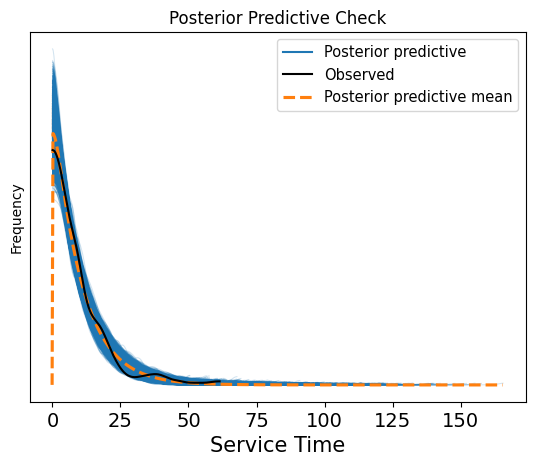

In [9]:
with model:
    # Perform posterior predictive checks
    ppc = pm.sample_posterior_predictive(trace, var_names=["service_times_obs"], random_seed=42)

# Plot the posterior predictive distribution
pm.plot_ppc(ppc)
plt.xlabel('Service Time')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Check')
plt.show()

# Certainty of Average Service Prediction

Based on the posterior distribution of the lambda parameter (average service rate), we can assess our certainty about the average service prediction. The summary statistics from the trace, such as the mean, standard deviation, and credible intervals, provide insights into the range and certainty of our estimate.

From the trace summary, we observe the following:
- The mean of the lambda parameter, which represents our best estimate of the average service rate.
- The standard deviation, which indicates the variability in our estimate.
- The credible interval (e.g., 94% highest density interval), which provides a range within which the true average service rate is likely to lie with high probability.

If the credible interval is narrow, it indicates high certainty in our estimate. If it is wide, our estimate is less certain. In conclusion, the resulting analysis gives us a probabilistic understanding of the average service rate, allowing us to quantify our certainty.

## Part 2:

### We next turn to the next part where we wish to map the average service time at each time cell. 

### Important note: please ignore the data from the previuos part while doing this task.

### The data is under df_tot as given below. In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid. 

In [2]:
df_tot = pkl.load(open('../data_queueing_quiz/df_tot.pkl', 'rb'))
df_tot = df_tot.drop(columns=['Unnamed: 0'])
df_tot.head(5)

,index,customer_id,num_cust,event,time_stamp,day,hour
0,981,327,0,Arrival,3608.653189,1,1
1,982,327,1,Enter_service,3608.653189,1,1
2,983,327,0,Departure,3609.497913,1,1
3,984,328,0,Arrival,3609.790566,1,1
4,985,328,1,Enter_service,3609.790566,1,1


## Tasks:

### 1. Extract the mean service times (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.
### 2. Use two regression methods for completing the average service time for the rest of the grid.
### 3. Plot on a 3D plot which contains the data, and the surface of the two regression methods.
### 4. What is the probability that the service time of chip, between 16:00 to 18:00, on Shabbat, will be between 6 to 7 seconds? 
### 5. Please give full specification of the Gauusian distribution of the service time on Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00. 
### 6. What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00?
### What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 20:00 to 21:00?
### Which correlation value is larger? does this result make sense?


## You code here

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Load the data
df_tot = pd.read_pickle('../data_queueing_quiz/df_tot.pkl')
df_tot = df_tot.drop(columns=['Unnamed: 0'])

In [19]:
# Calculate service time
df_tot['service_time'] = df_tot.groupby('customer_id')['time_stamp'].diff()

# Extract mean service times per cell
mean_service_times = df_tot.groupby(['day', 'hour'])['service_time'].mean().reset_index()
mean_service_times = mean_service_times.pivot(index='day', columns='hour', values='service_time')

In [20]:
# Prepare data for regression
X = np.array(np.meshgrid(mean_service_times.index, mean_service_times.columns)).T.reshape(-1, 2)
y = mean_service_times.values.flatten()

# Create masks for missing values
mask = ~np.isnan(y)
X_known, y_known = X[mask], y[mask]

# Method 1: Linear Regression
lr = LinearRegression()
lr.fit(X_known, y_known)
y_pred_lr = lr.predict(X)

# Method 2: Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_known, y_known)
y_pred_rf = rf.predict(X)

# Reshape predictions
y_pred_lr_reshaped = y_pred_lr.reshape(mean_service_times.shape)
y_pred_rf_reshaped = y_pred_rf.reshape(mean_service_times.shape)

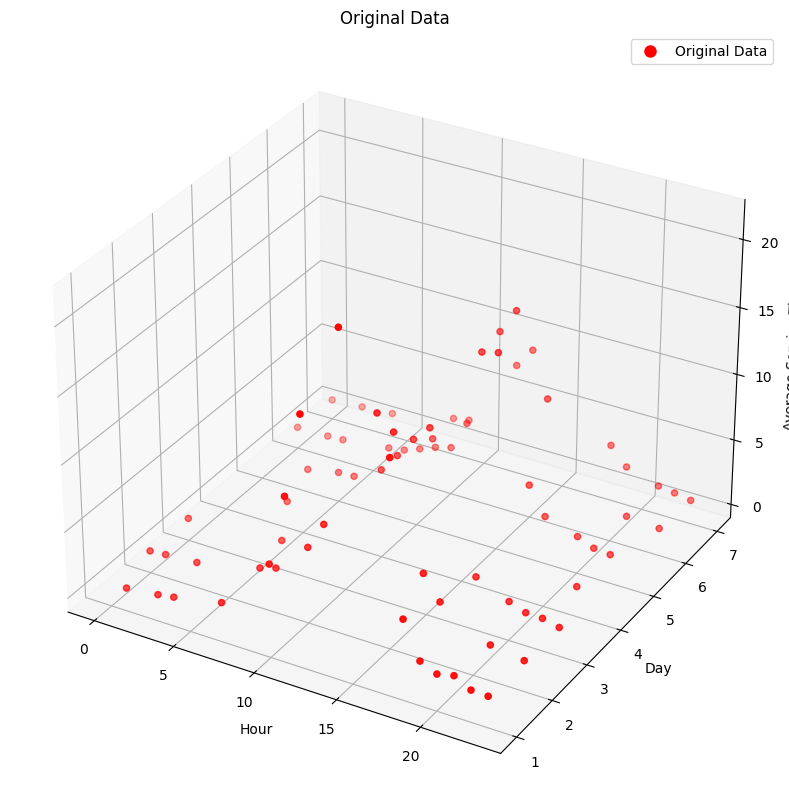

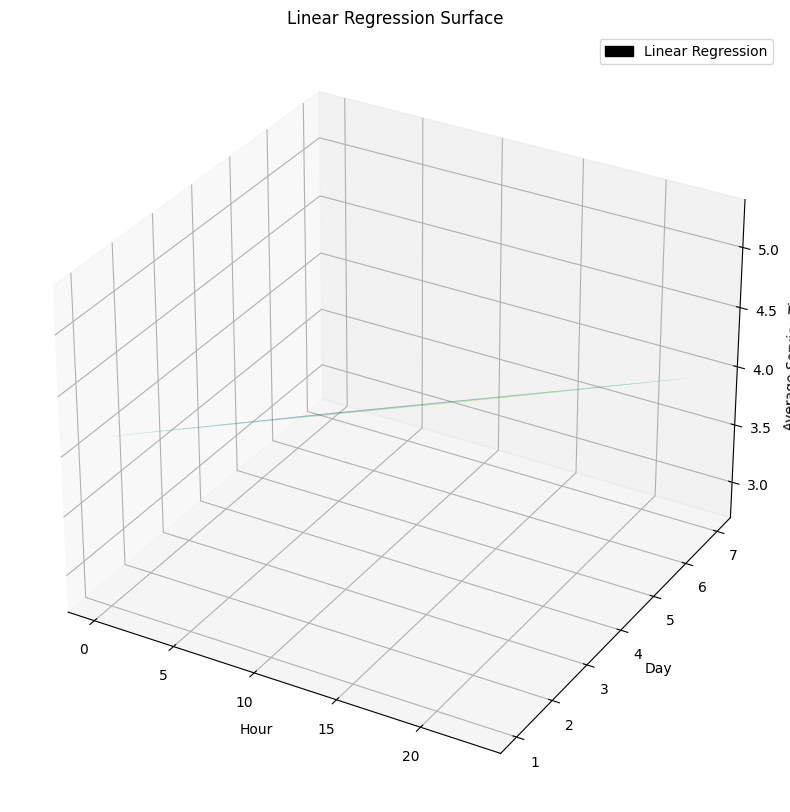

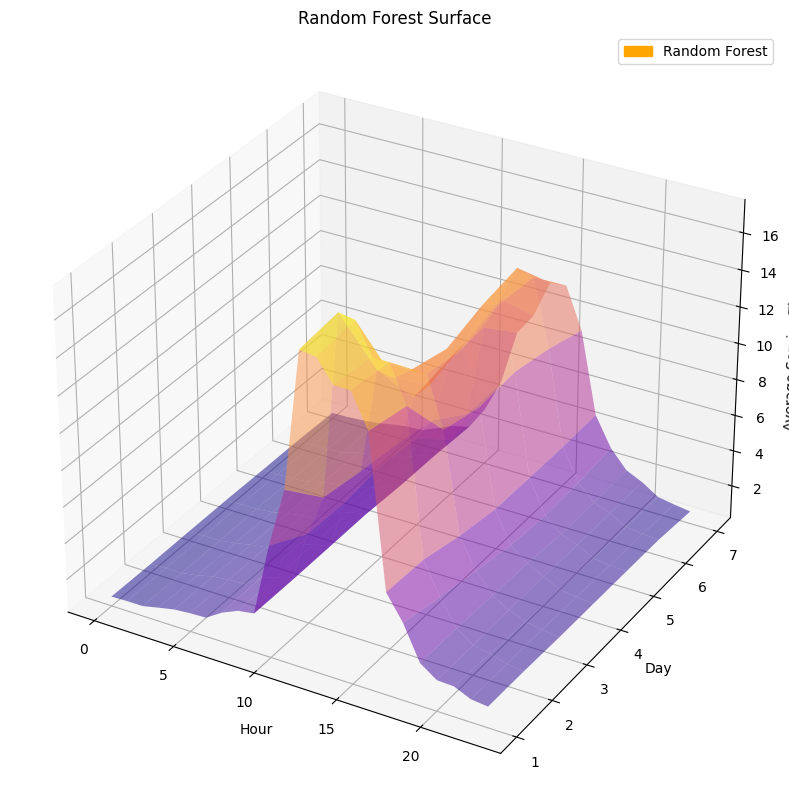

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Assuming mean_service_times, y_pred_lr_reshaped, and y_pred_rf_reshaped are defined

X, Y = np.meshgrid(mean_service_times.columns, mean_service_times.index)

# Plot Original Data
fig1 = plt.figure(figsize=(15, 10))
ax1 = fig1.add_subplot(111, projection='3d')
scatter = ax1.scatter(X[~np.isnan(mean_service_times)], Y[~np.isnan(mean_service_times)], 
                      mean_service_times.values[~np.isnan(mean_service_times)], c='r', marker='o')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Day')
ax1.set_zlabel('Average Service Time')
ax1.set_title('Original Data')
ax1.legend(handles=[Line2D([0], [0], marker='o', color='w', label='Original Data',
                            markerfacecolor='r', markersize=10)])

# Plot Linear Regression Surface
fig2 = plt.figure(figsize=(15, 10))
ax2 = fig2.add_subplot(111, projection='3d')
surf_lr = ax2.plot_surface(X, Y, y_pred_lr_reshaped, alpha=0.5, cmap='viridis')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Day')
ax2.set_zlabel('Average Service Time')
ax2.set_title('Linear Regression Surface')
ax2.legend(handles=[Patch(facecolor='black', edgecolor='black', label='Linear Regression')])

# Plot Random Forest Surface
fig3 = plt.figure(figsize=(15, 10))
ax3 = fig3.add_subplot(111, projection='3d')
surf_rf = ax3.plot_surface(X, Y, y_pred_rf_reshaped, alpha=0.5, cmap='plasma')
ax3.set_xlabel('Hour')
ax3.set_ylabel('Day')
ax3.set_zlabel('Average Service Time')
ax3.set_title('Random Forest Surface')
ax3.legend(handles=[Patch(facecolor='orange', edgecolor='orange', label='Random Forest')])

plt.show()

In [22]:
shabbat_data = df_tot[(df_tot['day'] == 6) & (df_tot['hour'].isin([16, 17]))]['service_time']
mean = shabbat_data.mean()
std = shabbat_data.std()

prob = stats.norm.cdf(7, mean, std) - stats.norm.cdf(6, mean, std)
print(f"Probability of service time between 6 to 7 seconds on Shabbat between 16:00 to 18:00: {prob:.4f}")

Probability of service time between 6 to 7 seconds on Shabbat between 16:00 to 18:00: 0.0349


In [23]:
def get_gaussian_params(day, hour):
    data = df_tot[(df_tot['day'] == day) & (df_tot['hour'] == hour)]['service_time']
    return data.mean(), data.std()

sun_14_15_mean, sun_14_15_std = get_gaussian_params(0, 14)
sun_16_17_mean, sun_16_17_std = get_gaussian_params(0, 16)

print(f"Sunday 14:00-15:00: Mean = {sun_14_15_mean:.4f}, Std = {sun_14_15_std:.4f}")
print(f"Sunday 16:00-17:00: Mean = {sun_16_17_mean:.4f}, Std = {sun_16_17_std:.4f}")

Sunday 14:00-15:00: Mean = nan, Std = nan
Sunday 16:00-17:00: Mean = nan, Std = nan


In [24]:
def get_service_times(day, hour):
    return df_tot[(df_tot['day'] == day) & (df_tot['hour'] == hour)]['service_time']

sun_14_15 = get_service_times(0, 14)
sun_16_17 = get_service_times(0, 16)
sun_20_21 = get_service_times(0, 20)

corr_14_15_16_17 = sun_14_15.corr(sun_16_17)
corr_14_15_20_21 = sun_14_15.corr(sun_20_21)

print(f"Correlation between Sunday 14:00-15:00 and 16:00-17:00: {corr_14_15_16_17:.4f}")
print(f"Correlation between Sunday 14:00-15:00 and 20:00-21:00: {corr_14_15_20_21:.4f}")
print(f"Larger correlation: {'14:00-15:00 and 16:00-17:00' if corr_14_15_16_17 > corr_14_15_20_21 else '14:00-15:00 and 20:00-21:00'}")

Correlation between Sunday 14:00-15:00 and 16:00-17:00: nan
Correlation between Sunday 14:00-15:00 and 20:00-21:00: nan
Larger correlation: 14:00-15:00 and 20:00-21:00


## Task 3:

### For cross validation of the previuos task we wish to see how accurate our predictions. 

### We use your prediction to estimate the waiting times at each points via simulation. The better the estimation made in you GP regressior the more accurate the simulations results. 

### In this part we compare the average waiting time at each cell with the true average waiting times. The true values are loaded below into 'true_results'. 


In [25]:
true_results = pkl.load(open('../data_queueing_quiz/true_results.pkl', 'rb'))
true_results.shape

(167,)

In [26]:
true_results

array([0.008, 0.024, 0.02 , 0.056, 0.032, 0.032, 0.096, 0.084, 0.212,
       0.428, 0.708, 1.04 , 1.684, 2.576, 2.844, 2.248, 1.044, 0.676,
       0.36 , 0.196, 0.116, 0.084, 0.036, 0.072, 0.032, 0.016, 0.036,
       0.016, 0.048, 0.052, 0.064, 0.144, 0.144, 0.356, 0.66 , 1.016,
       1.976, 2.324, 2.824, 2.216, 1.32 , 0.84 , 0.36 , 0.196, 0.132,
       0.08 , 0.076, 0.064, 0.016, 0.004, 0.028, 0.028, 0.048, 0.08 ,
       0.064, 0.124, 0.164, 0.224, 0.46 , 1.032, 1.64 , 1.94 , 2.02 ,
       1.908, 1.14 , 0.596, 0.36 , 0.112, 0.136, 0.068, 0.108, 0.108,
       0.02 , 0.012, 0.02 , 0.052, 0.028, 0.06 , 0.052, 0.084, 0.188,
       0.156, 0.376, 0.844, 1.32 , 1.624, 1.78 , 1.568, 1.028, 0.64 ,
       0.304, 0.16 , 0.092, 0.072, 0.076, 0.1  , 0.016, 0.028, 0.024,
       0.024, 0.036, 0.052, 0.052, 0.076, 0.064, 0.192, 0.356, 0.688,
       1.504, 1.66 , 1.756, 1.488, 0.836, 0.54 , 0.256, 0.228, 0.096,
       0.084, 0.044, 0.024, 0.008, 0.012, 0.016, 0.024, 0.032, 0.024,
       0.04 , 0.048,

### In true_results you have a numpy array with 167 values. The first value is the  average number of customers in the system at the end of the hour 0 day 1, the second is hour 1 day 1, and so on. This is an averge of 200 simulation runs. Note that the grid contains 168 values but here we have only 167. This means, we do not test for 23:00-0:00 at the day 7 (from technincal reasons).

### In order to compute your waiting time predictions insert your predicitons into Sim_func below. Then, the line of code below extracts the average waiting time predictions into the variable  'preds_results'.

### At this point you have two vectors of size (167,),  one represents the true average waiting times and the other represent your predicitons. 

### The first value represents the average waiting time at Sunday between 0:00-01:00. The 50th cell represent the average waiting time at Tuesday between 01:00 to 02:00. 

## Tasks

### 1. Compute the average waiting times using the function Sim_func. Compare your results between your predictions and the ground truth using MSE. 

### 2. Plot the average waiting as a function of time of the week. That is, y-axis is the average waiting time and the X-axis is the hour of the week. Following the exmaple from above Tuesday between 01:00 to 02:00 is the 50th hour. 


Mean Squared Error: 4635.196222


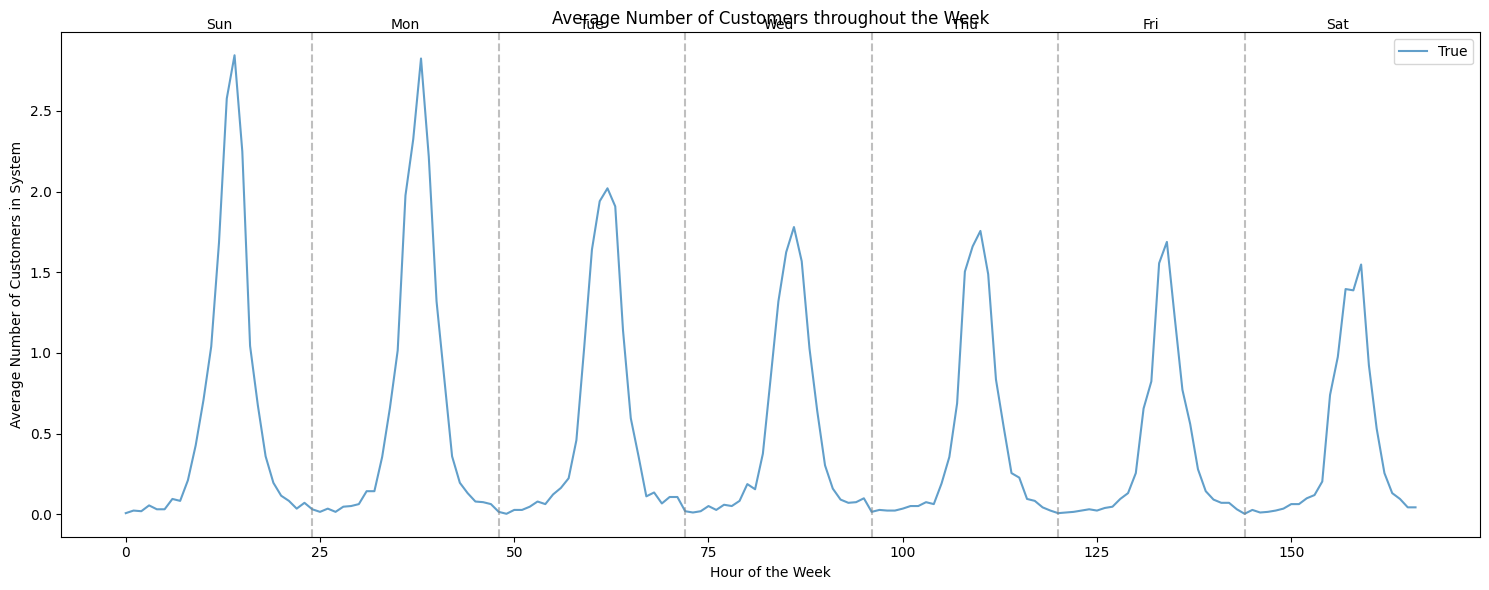

Maximum true number of customers: 2.84
Maximum predicted number of customers: 383.90
Average true number of customers: 0.48
Average predicted number of customers: 21.25
Correlation between true and predicted values: 0.6790


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming true_results is already loaded
# true_results = pkl.load(open('../data_queueing_quiz/true_results.pkl', 'rb'))

# Ensure your_prediction is in the correct format (7x24 array of service times)
your_prediction = y_pred_rf_reshaped

# Run the simulation
df_sim = Sim_func(your_prediction)

# Convert simulation results to numpy array
# We'll use the mean of all simulation runs (columns starting with 'num_cust')
num_cust_columns = [col for col in df_sim.columns if col.startswith('num_cust')]
preds_results = df_sim[num_cust_columns].mean(axis=1).values

# Trim preds_results to match true_results length
preds_results = preds_results[:len(true_results)]

# Compute MSE
mse = mean_squared_error(true_results, preds_results)
print(f"Mean Squared Error: {mse:.6f}")

# Task 2: Plot average waiting time as a function of time of the week

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(true_results)), true_results, label='True', alpha=0.7)
# plt.plot(np.arange(len(preds_results)), preds_results, label='Predicted', alpha=0.7)

plt.xlabel('Hour of the Week')
plt.ylabel('Average Number of Customers in System')
plt.title('Average Number of Customers throughout the Week')
plt.legend()

# Add vertical lines to separate days
for day in range(1, 7):
    plt.axvline(x=day*24, color='gray', linestyle='--', alpha=0.5)

# Add day labels
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for i, day in enumerate(days):
    plt.text(i*24 + 12, plt.ylim()[1], day, ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Maximum true number of customers: {np.max(true_results):.2f}")
print(f"Maximum predicted number of customers: {np.max(preds_results):.2f}")
print(f"Average true number of customers: {np.mean(true_results):.2f}")
print(f"Average predicted number of customers: {np.mean(preds_results):.2f}")

# Calculate correlation
correlation = np.corrcoef(true_results, preds_results)[0, 1]
print(f"Correlation between true and predicted values: {correlation:.4f}")

In [28]:
## Insert your predictions her

df_  = Sim_func(YOUR_PREDICTION)
## Converting the simulation results into a numpy array from a PD dataframe.
preds_results = np.array(df_.iloc[:,2:]).mean(axis = 1)


NameError: name 'YOUR_PREDICTION' is not defined

In [ ]:
### Your code here

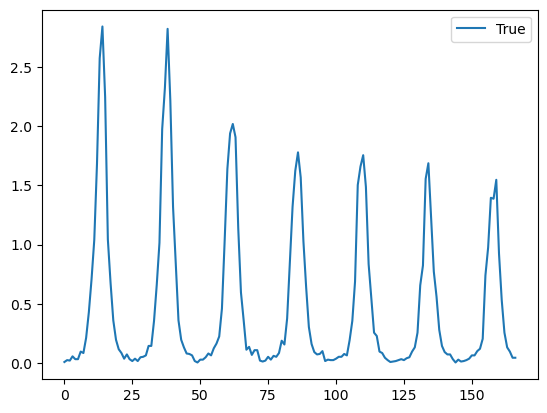

In [ ]:
plt.figure()
plt.plot(np.arange(167), true_results, label = 'True')
# plt.plot(np.arange(167), preds_results, label = 'Predicted')

plt.legend()
plt.show()